Let's first import the necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn

framingham = pd.read_csv("framingham.csv")


Now, let's look at the first 5 observations of the data set. Moreover, we can also take check the dimensions of the data set, and so forth.

In [3]:
print(framingham.head())
print(framingham.shape)

   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2 

Let's take a look at what each variable is:

    1. male (binary; 0 represents female, 1 represents male)
    
    2. age (integer)
    
    3. education (float; represents the number of years of higher level education)
    
    4. curretSmoker (int; smokes or not)
    
    5. cigsPerDay (float; number of cigarretes)
    
    6. BPMeds (binary; whether the patient is on heart medications)
    
    7. prevalentStroke (binary; whether the patient had previous heart attacks)
    
    8. prevalentHyp (binary; whether the patient was hypertensive)
    
    9. Diabetes (binary; whether the patient had diabetes)
    
    10. totChol (float; total cholesterol level)
    
    11. sysBP (float; systemic blood pressure)
    
    12. diaBP (float; diastolic blood pressure)
    
    13. BMI (float; body mass index)
    
    14. heartRate (float; heartrate)
    
    15. glucose (float; glucose level)
    
    16. TenYearCHD (binary; 1 represents the patient has developed a 10 yeah CHD, 0 otherwise), also the target.

Now, let's remove the missing values. 

In [4]:
# Drop all missing values
framingham = framingham.dropna()


Let's plot the histograms of each variable to get a general sense of the distributions of each predictor

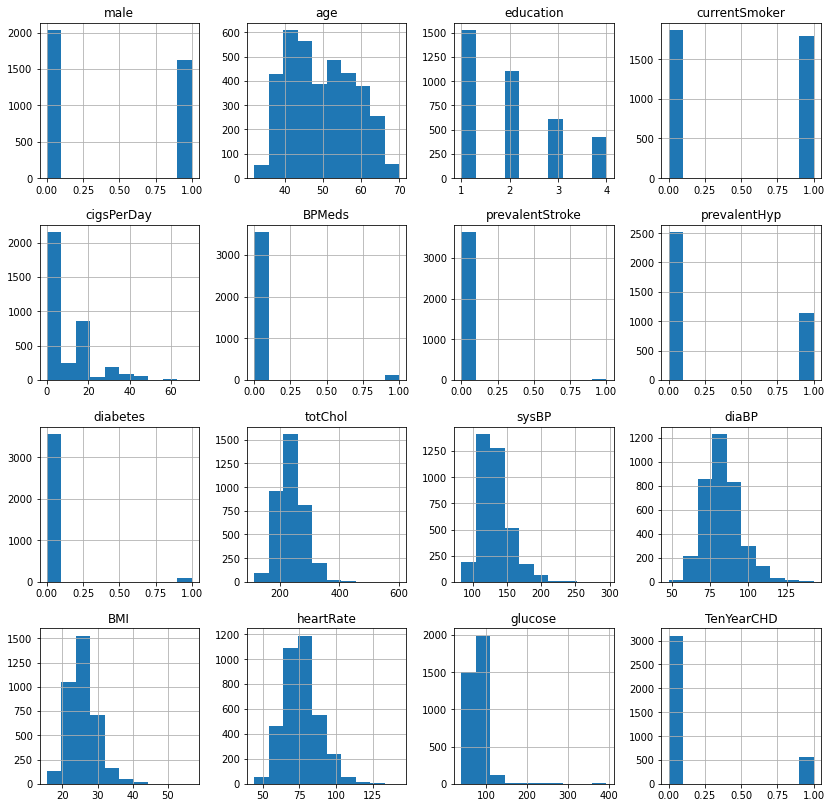

In [5]:
# Exploratory data analysis
framingham.dtypes

fig, axis = plt.subplots(4,4,figsize=(14, 14))
framingham.hist(ax=axis)
plt.show()


We see that age, totChol, sysBP, diaBP, BMI, heartRate all seem to be normally distributed whereas the other variables seem to exhibit some skwedness. 

We can also plot the correlation matrix below to look at the correlation between pairs of variables. Lighter colours mean a correlation close to 1, whereas darker colours represent a correlation closer to -1. We should be on the lookout for little multicollinearity between variables, in other words, low correlation between pairs of variables.

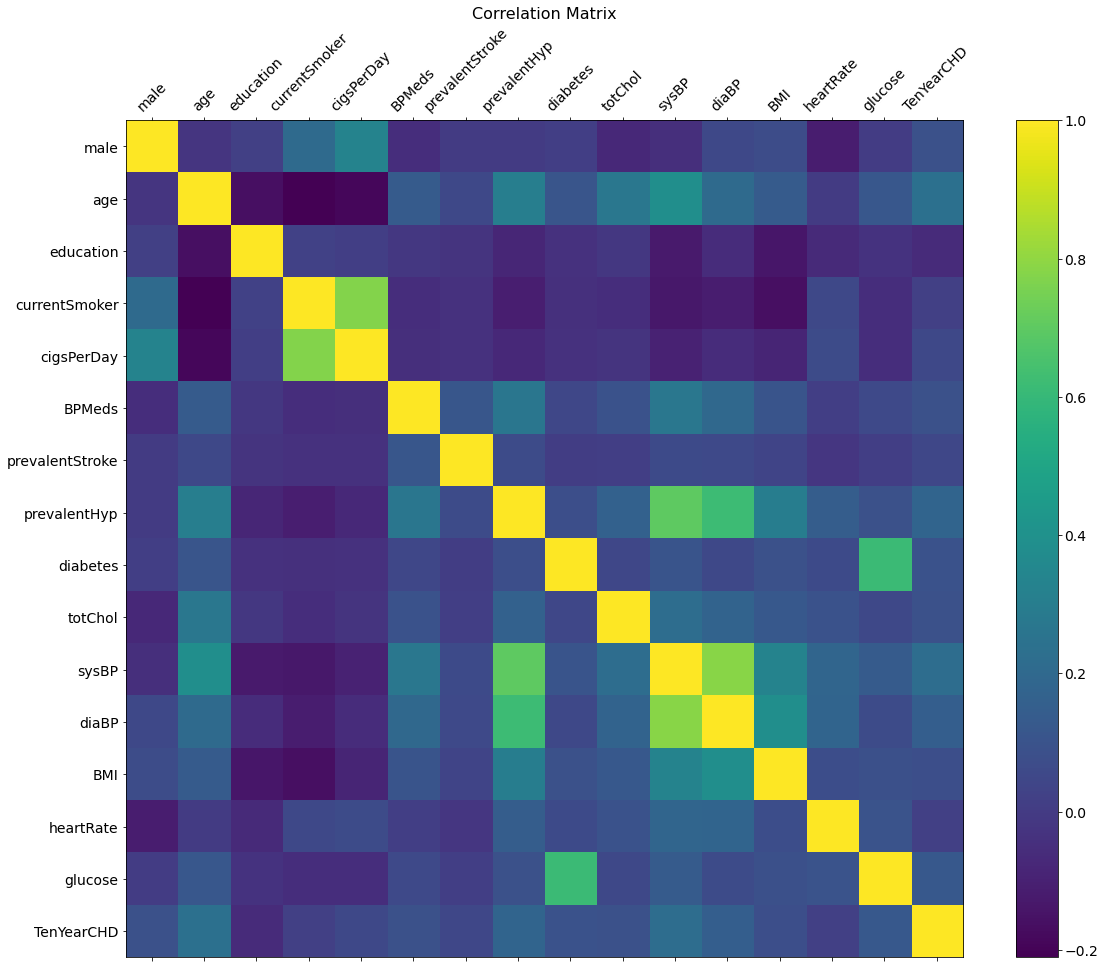

In [6]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(framingham.corr(), fignum=f.number)
plt.xticks(range(framingham.select_dtypes(['number']).shape[1]), framingham.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(framingham.select_dtypes(['number']).shape[1]), framingham.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

One of the first observations is that having both predictors currentSmoker and cigsPerDay is redundant. If somebody smokes more than one cig per day, then they are definetely a smoker, and vice versa. The correlation matrix also shows a correlation of around 0.8 between them. As a consequence, we can remove the predictor currentSmoker. 

Moreover, the matrix also suggests that there is strong correlation between the systemic and diastolic blood pressure. In fact, this paper: https://journals.lww.com/jhypertension/Abstract/2008/02000/Linear_relationship_between_systolic_and_diastolic.10.aspx suggests that there is a linear relationship between those two measures of blood pressure. For the sake of this project, let's remove the systolic blood pressure.

In [7]:
framingham_final = framingham.drop(columns=["education", "currentSmoker", "sysBP"])
data = framingham_final.iloc[:,:12]
targets = framingham_final.iloc[:, -1]


Now, let's create the train, validation, test sets using a 70/15/15 split.

In [8]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(data, targets, test_size=0.30, stratify=targets)
train_X, val_X, train_Y, val_Y = train_test_split(test_X, test_Y, test_size=0.50) 


One thing that might be problematic is that the ranges of each variable differ tremendously. In particular, some variables are either 0 or 1, whereas other variables such as totChol are in the 300s. Let's perform min-max scaling to make all variables vary from 0 to 1.

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(train_X)

Now, let's train a model. We'll start with logistic regression, using 10000 iterations. We'll keep these hyperparameters like this for now, we will tune them in the validation set. 

In [10]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(max_iter=1000)
logistic.fit(scaled_X, train_Y)


LogisticRegression(max_iter=1000)

Let's try this new model with some a couple of data just for fun.

In [11]:
some_data = data[:30]
some_labels = targets[:30]
some_data_transformed = scaler.fit_transform(some_data)
print("Predictions:\t", logistic.predict(some_data_transformed))
print("Labels:\t\t", list(some_labels))




Predictions:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:		 [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]


As you can see the predictions are decent on 30 data points. We misclassified 5 data points.

Let's calculate the cross-entropy loss to check the error of our predictions.

In [44]:
from sklearn.metrics import accuracy_score
predictions_log = logistic.predict(scaled_X)
accuracy_score(train_Y, predictions_log)

0.8594890510948905

We obtain an accuracy score of 84%, which is alright. Let's see if we can do better by training other models.

Let's start with the Naïve Bayes.

In [43]:
from sklearn.naive_bayes import GaussianNB
bng = GaussianNB()
bng.fit(scaled_X, train_Y)
predictions_bng = bng.predict(scaled_X)
accuracy_score(train_Y, predictions_bng)

0.8321167883211679

We get a lower accuracy score. A priori, a Gaussian Naive Bayes assumes that each feature is normally distributed. We could try to use standardized scaling instead of min-max scaling to see if we get a better score.

In [42]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
norm_X = stdscaler.fit_transform(train_X)


bng.fit(norm_X, train_Y)
predictions_bng = bng.predict(norm_X)
accuracy_score(train_Y, predictions_bng)

0.8321167883211679

For some reason we get the same accuracy score as the logistic regression.

Let's try K-NN with K = 5.

In [41]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(scaled_X, train_Y)
predictions_neigh = neigh.predict(scaled_X)
accuracy_score(train_Y, predictions_neigh)

0.8631386861313869

Nice! We get an accuracy score of 85%. We've classified correctly 85% of the labels.

Let's try using a SVM.

In [16]:
from sklearn import svm
sv = svm.SVC()
sv.fit(scaled_X, train_Y)
predictions_svm = sv.predict(scaled_X)
accuracy_score(train_Y, predictions_svm)


0.8558394160583942

Let's try with a Decision Tree.

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(scaled_X, train_Y)
predictions_tree = dtc.predict(scaled_X)
accuracy_score(train_Y, predictions_tree)

1.0

This looks like our tree has overfitted the training set.

To verify this claim, we can perform a K-fold cross validation. Essentially, we divide our training set into K subsets, training the model K times, each time on K-1 folds and testing on the remaining 1 fold. Let's use K=10

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dtc, scaled_X, train_Y, scoring="accuracy", cv=10)

print("Scores:", scores) 
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [0.81818182 0.72727273 0.83636364 0.72727273 0.63636364 0.76363636
 0.8        0.72727273 0.7962963  0.7962963 ]
Mean: 0.7628956228956228
Standard deviation: 0.05646230738285075


Using a K-fold cross validation, we see that the Decision Tree is performing much worse that what it seemed before. 

Let's see what would happen if we do cross-validation with KNN.

In [19]:
scores_knn = cross_val_score(neigh, scaled_X, train_Y)

print("Scores:", scores_knn) 
print("Mean:", scores_knn.mean())
print("Standard deviation:", scores_knn.std())


Scores: [0.85454545 0.84545455 0.8        0.79816514 0.85321101]
Mean: 0.8302752293577982
Standard deviation: 0.025663799282393623


Looks better.

Finally, let's train a neural network.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(units=32, activation="relu", input_dim = len(train_X.columns)))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="sgd", metrics="accuracy")
model.fit(scaled_X, train_Y, epochs =200, batch_size=32)

Epoch 1/200
18/18 [==============================] - 0s 882us/step - loss: 0.5839 - accuracy: 0.8504
Epoch 2/200
18/18 [==============================] - 0s 984us/step - loss: 0.5491 - accuracy: 0.8504
Epoch 3/200
18/18 [==============================] - 0s 1ms/step - loss: 0.5233 - accuracy: 0.8504
Epoch 4/200
18/18 [==============================] - 0s 1ms/step - loss: 0.5011 - accuracy: 0.8504
Epoch 5/200
18/18 [==============================] - 0s 1ms/step - loss: 0.4851 - accuracy: 0.8504
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.8504
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.8504
Epoch 8/200
18/18 [==============================] - 0s 1ms/step - loss: 0.4549 - accuracy: 0.8504
Epoch 9/200
18/18 [==============================] - 0s 1ms/step - loss: 0.4484 - accuracy: 0.8504
Epoch 10/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.8504
Epoch

18/18 [==============================] - 0s 1ms/step - loss: 0.3917 - accuracy: 0.8504
Epoch 83/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3914 - accuracy: 0.8504
Epoch 84/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3912 - accuracy: 0.8504
Epoch 85/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3910 - accuracy: 0.8504
Epoch 86/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3907 - accuracy: 0.8504
Epoch 87/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3904 - accuracy: 0.8504
Epoch 88/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3901 - accuracy: 0.8504
Epoch 89/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3897 - accuracy: 0.8504
Epoch 90/200
18/18 [==============================] - 0s 983us/step - loss: 0.3895 - accuracy: 0.8504
Epoch 91/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3893 - accuracy: 0.8504
Epoch 92/20

18/18 [==============================] - 0s 1ms/step - loss: 0.3789 - accuracy: 0.8504
Epoch 164/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3789 - accuracy: 0.8504
Epoch 165/200
18/18 [==============================] - 0s 983us/step - loss: 0.3788 - accuracy: 0.8504
Epoch 166/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3786 - accuracy: 0.8504
Epoch 167/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3785 - accuracy: 0.8504
Epoch 168/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3783 - accuracy: 0.8504
Epoch 169/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3783 - accuracy: 0.8504
Epoch 170/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3782 - accuracy: 0.8504
Epoch 171/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3783 - accuracy: 0.8504
Epoch 172/200
18/18 [==============================] - 0s 1ms/step - loss: 0.3781 - accuracy: 0.8504
Ep

In [45]:
predictions_ynn = model.predict(scaled_X)
predictions_ynn = [0 if val<0.5 else 1 for val in ynn]
accuracy_score(train_Y, predictions_ynn)

0.8503649635036497

We get an accuracy of 85%. The model that achieved the best performance is  The next step is to validate the model. 